# Modeling the Glucose-Insulin system

#### Bonnie Cooper
<br><br>  

## Implement the minimal model of glucose and insulin in the blood stream.

### Definitions: The Glucose-Insulin System

**Glucose** a form of sugar that circulates in the blood stream of animals and is metabolized as the most common fuel for typical cellular processes.  
**Insulin** a hormone produced by the pancreas that acts to lower blood glucose levels.  
**Hyperglycemia** when blood sugar levels become elevated.
**Hypoglycemia** when blood sugar levels are depressed.
**Diabetes Mellitus** a condition characterized by hyperglycemia because the body does not produce enough insulin &/or does not properly respond to the insulin that the body produces.
**Frequently Sampled Intravenous Glucose Tolerance Test (FSIGT)** one of the most common tests for hyperglycemia &/or diabetes mellitus. a glucose injection is administered to a fasting subject. subsequently, a series of blood samples are drawn in intervals for several hours. from these samples, blood glucose measurements are obtained which describes the subjects ability to metabolize glucose.

### The Glucose Minimal Model
The Minimal Model is a model in two parts: the glucose model and the insulin model. First described by Bergman *et al* (1), the model seeks 'the simplest model based on known physiology that could account for the insulin-glucose relationship revealed in the data.' The goal of this model is to estimate the model parameters given a dataset and to be ableto interpret the model parameters meanigfully. Blood glucose levels are modeled to decrease in the blood due to two main effects: the blood glucose's natural tendancy to normalize in concentraion and the effects of insulin. Insulin if found to have a relatively longer latency to action.  

The Glucose Minimal Model consists of 2 differential equations:

1. $$ \frac{dG}{dt} = -k_1[G(t) - G_b] - X(t)G(t)$$
2. $$ \frac{dX}{dt} = k_3[I(t) - I_b] - k_2X(t)$$ 

where  
* $G$ [ blood glucose ] as a function of time
* $X$ [ insulin ] as a function of time
* $I$ [ insulin ] as a function of time measured from the patient
* $G_b$ & $I_b$ [ blood glucose ] & [ insulin ] basal at equilibrium
* $\frac{dG}{dt}$ & $\frac{dX}{dt}$ rates of change
* $k_1$, $K_2$ and $k_3$ model parameters

We can interpret the equations as follows:
1. the rate of change of blood glucose concentration as a function of time can be described by the rate of glucose disappearance due to the effects of glucose itself and the rate of glucose disappearance due to the effects of insulin
2. the rate of change of blood insulin concentration as a function of time can be described by the rate that insulin diffuses from blood to interstitial fluid and the rate that insulin is broken down in tissue.

### the Data

To test the Minimal Model, data from Pacini & Bergman (3) will be used.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#read data to a pandas dataframe
data = pd.read_csv( 'https://raw.githubusercontent.com/SmilodonCub/ModSimPy/master/notebooks/data/glucose_insulin.csv', index_col='time' )
data.head()

,glucose,insulin
time,,
0,92,11
2,350,26
4,287,130
6,251,85
8,240,51


Text(0.5, -0.05, 'This figure shows glucose and insulin concentrations over 182 min \nfor a subject with normal insulin production and sensitivity')

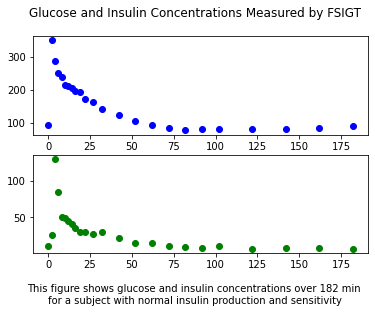

In [3]:
txt = 'This figure shows glucose and insulin concentrations over 182 min \nfor a subject with normal insulin production and sensitivity'
fig, axs = plt.subplots(2);
fig.suptitle('Glucose and Insulin Concentrations Measured by FSIGT');
axs[0].plot(data.index, data['glucose'], 'ob');
axs[1].plot(data.index, data['insulin'], 'og');
fig.text(.5, -0.05, txt, ha='center')

### Interpolation
The Pacini & Bergman data is a series of discrete timepoint measurements. Before we can implement the model, the data points need to be interpolated. **Interpolation** is a mathematical method that estimates values inbetween the given data points.

In [4]:
from scipy import interpolate as int
import numpy as np

In [5]:
I = int.interp1d( data.index, data.insulin, kind = 'linear')
G = int.interp1d( data.index, data.glucose, kind = 'linear')

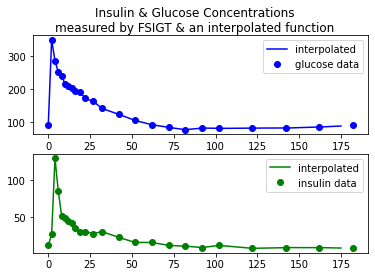

In [6]:
ts = np.linspace( 0, 175, num = 176, endpoint=True )

fig, axs = plt.subplots(2);
fig.suptitle('Insulin & Glucose Concentrations\nmeasured by FSIGT & an interpolated function');
axs[1].plot( ts, I(ts), 'g', label = 'interpolated');
axs[1].plot( data.index, data['insulin'], 'og', label = 'insulin data');
axs[1].legend()
axs[0].plot( ts, G(ts), 'b', label = 'interpolated');
axs[0].plot( data.index, data['glucose'], 'ob', label = 'glucose data');
axs[0].legend();

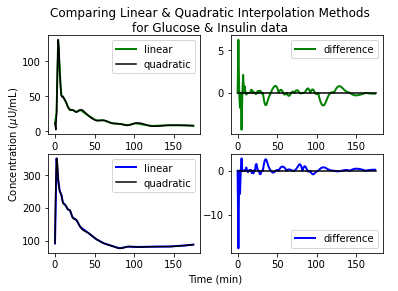

In [7]:
I2 = int.interp1d( data.index, data.insulin, kind = 'quadratic')
G2 = int.interp1d( data.index, data.glucose, kind = 'quadratic')
I_diff = (I(ts)-I2(ts))/G2(ts)*100
G_diff = (G(ts)-G2(ts))/G2(ts)*100

fig = plt.figure();
axBig = fig.add_subplot(111)
axBig.spines['top'].set_color('none')
axBig.spines['bottom'].set_color('none')
axBig.spines['left'].set_color('none')
axBig.spines['right'].set_color('none')
axBig.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
fig.suptitle('Comparing Linear & Quadratic Interpolation Methods\nfor Glucose & Insulin data');
axBig.set_xlabel('Time (min)')
axBig.set_ylabel('Concentration ($\mu$U/mL)')
ax0 = fig.add_subplot(223)
ax0.plot( ts, G(ts), 'b', linewidth=2, label = 'linear');
ax0.plot( ts, G2(ts), 'k', label = 'quadratic');
ax0.legend();
ax1 = fig.add_subplot(221)
ax1.plot( ts, I(ts), 'g', linewidth=2, label = 'linear');
ax1.plot( ts, I2(ts), 'k', label = 'quadratic');
ax1.legend()
ax2 = fig.add_subplot(222)
ax2.plot( ts[0:-1], I_diff[0:-1], 'g', linewidth=2, label = 'difference');
ax2.plot( ts, np.zeros(len(ts)), 'k');
ax2.legend()
ax3 = fig.add_subplot(224)
ax3.plot( ts[0:-1], G_diff[0:-1], 'b', linewidth=2, label = 'difference');
ax3.plot( ts, np.zeros(len(ts)), 'k');
ax3.legend();


The figure above plots the linear and quadratic interpolations of the data in the left hand column for blood glucose concentration (top panel) and blood insulin concentration (bottom panel). The envelope of the linear and quadratic series are very similar. To highlight the differences, the subplots in the right hand column show the relative differences for glucose and insulin interpolations (top and bottom figures respectively).

## The Glucose Model

The previous sections dealt with various interpolation methods to estimate values inbetween the provided datapoints. The following code will implement the minimal model of blood glucose levels by finding numerical solutions to the minimal model differential equations using two methods: Euler's method & Ralston's method. Euler's method evaluates the derivative of the system equations at discrete time intervals, so in this sense, it is a 1st order solution and really only very accurate to the 1st derivative. The Euler method can only yield an exact solutiion for linear problems. Ralston's method, on the other hand, is a second order solution and more advanced in that it involves an intermediate slope calculation. The slope calculation takes an intermediate value into account and therefore reduces the truncation error introduced to the numerical solution. Truncation error refers to the error incurred by discretizing data. Ralston's method is one in a family of Runge-Kutta methods that may have higher order solutions (accounting for higher order derivatives). The higher the order, the better a solution the complex series. In other words, the wavier and more irregular the data are better described by higher order methods. However, simple data series can be adequately described by Euler (1st order) and Ralston's (2nd order).  

### Euler's Method

In [8]:
class Params:
    """ Params class represents a collection of parameters. """

    def __init__(self, G0, k1, k2, k3):
        """ Create a new set of parameters """
        self.G0 = G0
        self.k1 = k1
        self.k2 = k2
        self.k3 = k3
        
class State:
    """State class represents the current state of the minimal model"""
    
    def __init__( self, G, X ):
        """Initialize State"""
        self.G = G
        self.X = X
        
class System:
    """Sytem class represents the minimal model system"""
    
    def __init__( self, params, initState, Gb, Ib, I, t_0, t_end, dt, k1, k2, k3 ):
        """Initialize System"""
        self.params = params
        self.initState = initState
        self.Gb = Gb
        self.Ib = Ib
        self.I = I
        self.t_0 = t_0
        self.t_end = t_end
        self.dt = dt
        self.k1 = k1
        self.k2 = k2
        self.k3 = k3

In [9]:
def make_system( params, data, timeStep ):
    """
    uses initial measurements from params & data to initialize a system
    params: a Params object
    data: a pandas dataframe
    timeStep: discrete time interval of data (mins)
    requires interpolate from scipy
    """
    dt = timeStep
    
    G0 = params.G0
    k1 = params.k1
    k2 = params.k2
    k3 = params.k3
    
    Gb = data.glucose[0]
    Ib = data.insulin[0]
    I = int.interp1d( data.index, data.insulin, kind = 'linear') 
    
    t_0 = data.index[0]
    t_end = data.index[-1]
    
    initState = State( G = G0, X=0 )
    
    return System( params, initState=initState, Gb=Gb, Ib=Ib, I=I, t_0=t_0, \
                  t_end=t_end, dt=dt, k1=k1, k2=k2, k3=k3 )

def update_func( state, t, system ):
    """
    Update the state of the system for a given increment of time
    state = a State() object
    system = a System() object
    """
    G, X = state.G, state.X
    k1, k2, k3 = system.k1, system.k2, system.k3
    I, Ib, Gb = system.I, system.Ib, system.Gb
    dt = system.dt
    
    dGdt = -k1 * ( G-Gb ) - X*G
    dXdt = k3 * ( I(t)-Ib ) - k2*X
    
    G += dGdt*dt
    X += dXdt*dt
    
    return State( G=G, X=X )

def run_simulation( system, update_func ):
    """
    rum minimal model simulation
    """
    init = system.initState
    #print( vars(init) )
    t_0, t_end, dt = system.t_0, system.t_end, system.dt
    
    num_steps = np.arange( t_0, t_end+dt, dt )
    #index_step = np.linspace( 0, len(num_steps), len(num_steps)+1, endpoint = True )
    resultSeries = np.empty( [len( num_steps),2] )
    resultSeries[ 0,0 ] = init.G
    resultSeries[ 0,1 ] = init.X
    #print( resultSeries)
    
    for aStep in range( len(num_steps)-1 ):
        currentState = State( G=resultSeries[ aStep, 0 ], X=resultSeries[ aStep, 1 ])
        nextState = update_func( currentState, num_steps[aStep], system )
        resultSeries[ aStep + 1,0 ] = nextState.G
        resultSeries[ aStep + 1,1 ] = nextState.X
        #print( 'Timestep:', aStep )
        #print( 'Current:', currentState.G, currentState.X )
        #print( 'Next', nextState.G, nextState.X )
    
    data = {'time': num_steps, 'G':resultSeries[:,0], 'X':resultSeries[:,1]}
    results_df = pd.DataFrame(data)
    return results_df   

In [10]:
params = Params( G0=290, k1 = 0.03, k2 = 0.02, k3 = 1e-05 )
print( vars( params ) )

{'G0': 290, 'k1': 0.03, 'k2': 0.02, 'k3': 1e-05}


In [11]:
aSys = make_system( params, data, 2 )

In [12]:
results = run_simulation( aSys, update_func );
results.head()

,time,G,X
0,0,290.00000,0.000000
1,2,278.12000,0.000000
2,4,266.95280,0.000300
3,6,256.29546,0.002668
4,8,245.07014,0.004041


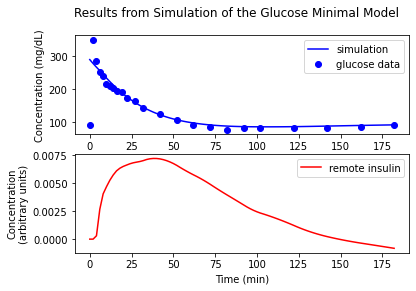

In [13]:
fig, axs = plt.subplots(2);
fig.suptitle('Results from Simulation of the Glucose Minimal Model');
axs[1].plot( results['time'], results['X'], 'r', label = 'remote insulin');
axs[1].legend()
axs[1].set_ylabel('Concentration\n(arbitrary units)')
axs[1].set_xlabel('Time (min)')
axs[0].plot( results['time'], results['G'], 'b', label = 'simulation');
axs[0].plot( data.index, data['glucose'], 'ob', label = 'glucose data');
axs[0].legend();
axs[0].set_ylabel('Concentration (mg/dL)');

### Ralston's Method

In [ ]:
from scipy.integrate import odeint

In [ ]:
def RalstonsMethod(f, y0, t, args=()):
    n = len(t)
    y = np.zeros((n, len(y0)))
    y[0] = y0
    for i in range(n - 1):
        h = t[i+1] - t[i]
        y[i+1] = y[i] + h * f(y[i] + f(y[i], t[i], *args) * h / 2., t[i] + h / 2., *args)
    return y

In [ ]:
def run_ralston(system, slope_func, **options):
    """Computes a numerical solution to a differential equation.

    `system` must contain `init` with initial conditions,
     and `t_end` with the end time.

     `system` may contain `t_0` to override the default, 0

    It can contain any other parameters required by the slope function.

    `options` can be ...

    system: System object
    slope_func: function that computes slopes

    returns: TimeFrame
    """
    # the default message if nothing changes
    msg = "The solver successfully reached the end of the integration interval."

    # get parameters from system
    init, t_0, t_end, dt = check_system(system, slope_func)

    # make the TimeFrame
    frame = TimeFrame(columns=init.index)
    frame.row[t_0] = init
    ts = linrange(t_0, t_end, dt) * get_units(t_end)

    event_func = options.get("events", None)
    z1 = np.nan

    def project(y1, t1, slopes, dt):
        t2 = t1 + dt
        y2 = [y + slope * dt for y, slope in zip(y1, slopes)]
        return y2, t2

    # run the solver
    for t1 in ts:
        y1 = frame.row[t1]

        # evaluate the slopes at the start of the time step
        slopes1 = slope_func(y1, t1, system)

        # evaluate the slopes at the two-thirds point
        y_mid, t_mid = project(y1, t1, slopes1, 2 * dt / 3)
        slopes2 = slope_func(y_mid, t_mid, system)

        # compute the weighted sum of the slopes
        slopes = [(k1 + 3 * k2) / 4 for k1, k2 in zip(slopes1, slopes2)]

        # compute the next time stamp
        y2, t2 = project(y1, t1, slopes, dt)

        # check for a terminating event
        if event_func:
            z2 = event_func(y2, t2, system)
            if z1 * z2 < 0:
                scale = magnitude(z1 / (z1 - z2))
                y2, t2 = project(y1, t1, slopes, scale * dt)
                frame.row[t2] = y2
                msg = "A termination event occurred."
                break
            else:
                z1 = z2

        # store the results
        frame.row[t2] = y2

    details = ModSimSeries(dict(success=True, message=msg))
    return frame, details

## References

1. Bergman, Richard N. "Minimal model: perspective from 2005." Hormone Research in Paediatrics 64.Suppl. 3 (2005): 8-15.
2. [CDC National Diabetes Statistics Report 2020](https://www.cdc.gov/diabetes/pdfs/data/statistics/national-diabetes-statistics-report.pdf)
3. Pacini, Giovanni, and Richard N. Bergman. "MINMOD: a computer program to calculate insulin sensitivity and pancreatic responsivity from the frequently sampled intravenous glucose tolerance test." Computer methods and programs in biomedicine 23.2 (1986): 113-122.
4. [Runge-Kutta methods for ODE integration in Python](https://perso.crans.org/besson/publis/notebooks/Runge-Kutta_methods_for_ODE_integration_in_Python.html)